# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

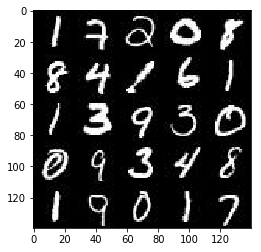

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

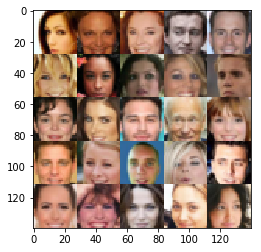

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(dtype=tf.float32)

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannels
        conv = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, padding='SAME', activation=None)
        # Output of Conv layer 1, 14x14x32
        
        conv = tf.layers.conv2d(inputs=conv, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv), alpha)
        # Output of Conv layer 2, 7x7x64
        
        conv = tf.layers.conv2d(inputs=conv, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv), alpha)
        # Output of Conv layer 3, 4x4x128
        
        logits = tf.reshape(conv,(-1, 4*4*128))
        logits = tf.contrib.layers.fully_connected(logits, 1, activation_fn=None)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator',reuse=not is_train):
        x = tf.contrib.layers.fully_connected(z, 7*7*256, activation_fn=None)
        x = tf.reshape(x, (-1,7,7,256))
        x = tf.nn.leaky_relu(tf.layers.batch_normalization(x, training=is_train), alpha)
        # First fully connected layer, 7x7x256

        conv = tf.layers.conv2d_transpose(inputs=x, filters=128, kernel_size=5, strides=2, padding='same', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv, training=is_train), alpha)
        # Output of Conv layer 1, 14x14x128
        
        conv = tf.layers.conv2d_transpose(inputs=conv, filters=64, kernel_size=5, strides=1, padding='same', activation=None)
        conv = tf.nn.leaky_relu(tf.layers.batch_normalization(conv, training=is_train), alpha)
        # Output of Conv layer 1, 28x28x64
        
        logits = tf.layers.conv2d_transpose(inputs=conv, filters=out_channel_dim, kernel_size=5, strides=2, padding='same', activation=None)
        # Output layer, 28x28xchannels
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # As per https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    #real_labels = tf.random_uniform(shape=tf.shape(d_model_real), minval=0.7, maxval=1.2)
    #fake_labels = tf.random_uniform(shape=tf.shape(d_model_fake), minval=0, maxval=0.3)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model   
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale data to have [-1,1] 
                batch_images *= 2

                # Sample random noise for G
                # Use gaussian as per https://github.com/soumith/ganhacks#3-use-a-spherical-z
                batch_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.7084


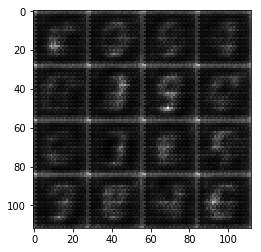

Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7136


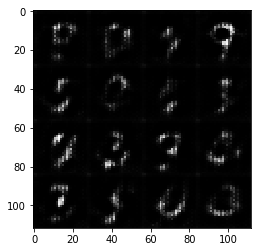

Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.6881
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.7523


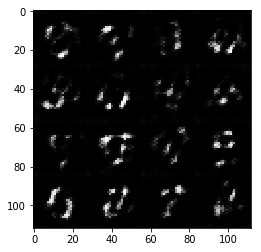

Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.7342
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.8272
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.7243


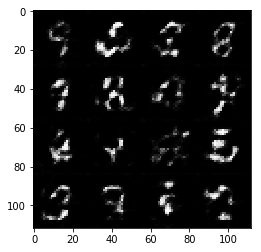

Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.9356


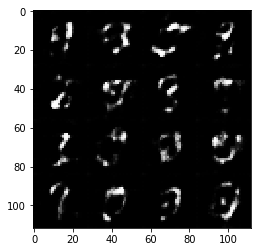

Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.8483
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.8067


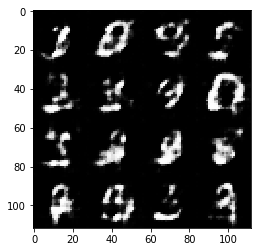

Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 0.7022
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7970
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7948


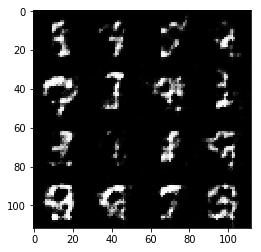

Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 0.8016
Epoch 1/2... Discriminator Loss: 1.3377... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7988
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.7673


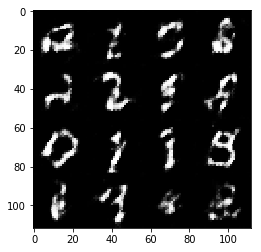

Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.8341
Epoch 1/2... Discriminator Loss: 1.4351... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 0.8730
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.8490
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.8197


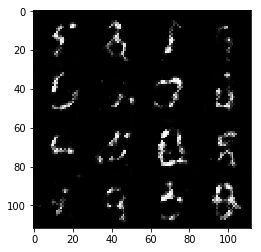

Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.3400... Generator Loss: 0.7590
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.8624
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.8988


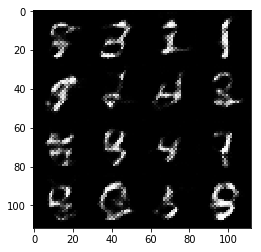

Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.9028
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.8053
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.8243
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.7300


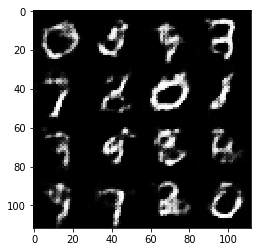

Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.7890
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.8316
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.8278


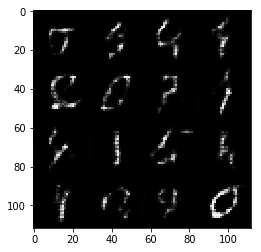

Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.8441


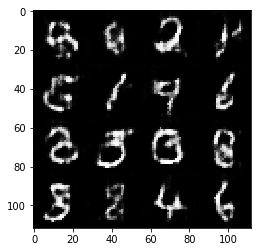

Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.8201
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.8889
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.3221... Generator Loss: 0.7972


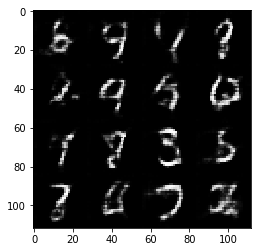

Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.8717
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.9349
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.7902
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8324


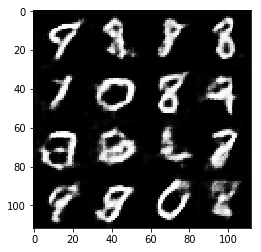

Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 0.8283
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.7893
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.7337
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.8586


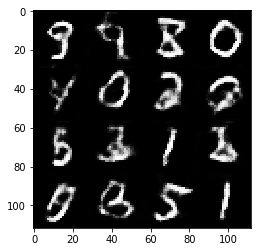

Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.8127
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.8282
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 0.8247


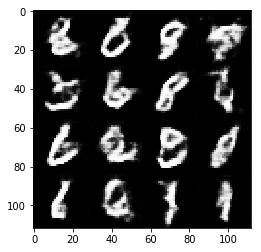

Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.8168
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.7612


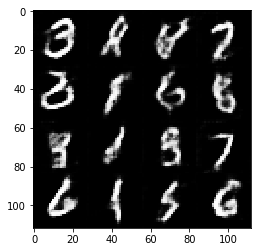

Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.7587
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.8842
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.8924
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.7857


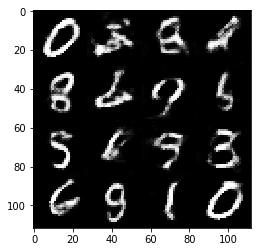

Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3348... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.8885
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3628... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.8774
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.7892


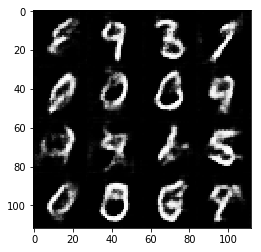

Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.7633
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.8602
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.3791... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.7081


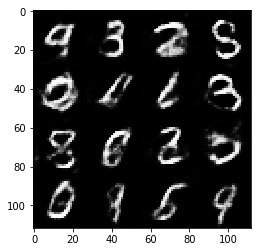

Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 0.8598
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 1.2303... Generator Loss: 0.9041
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.8671


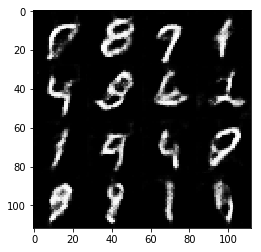

Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.8178
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 0.8070


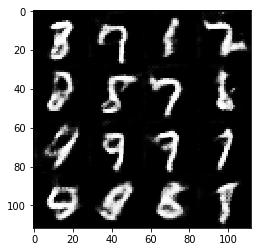

Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 1.3003... Generator Loss: 0.8242


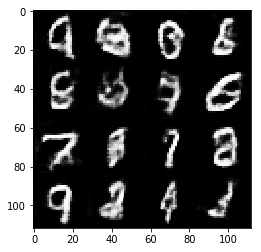

Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.3103... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.8455


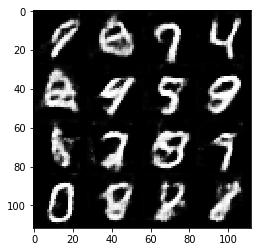

Epoch 2/2... Discriminator Loss: 1.3362... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 1.2649... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.2439... Generator Loss: 0.8842
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.7919


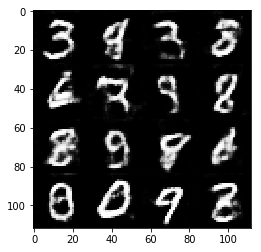

Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.9077
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8171
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7874


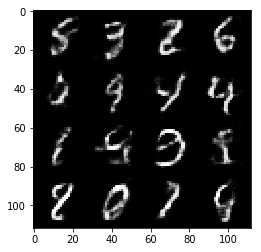

Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.3507... Generator Loss: 0.8601
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.8255


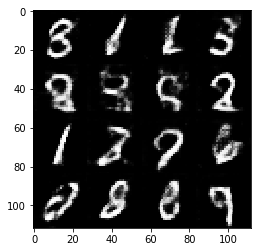

Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.8867
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 1.3626... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.3516... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.3783... Generator Loss: 0.8148


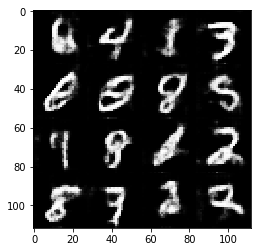

Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.7837
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3702... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.8862


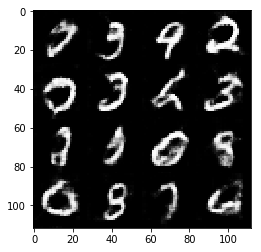

Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 1.4096... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.8009


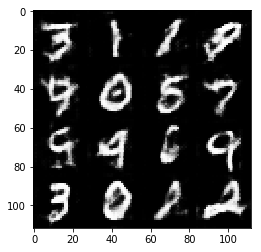

Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.8369


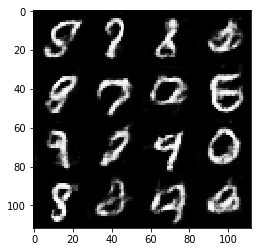

Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.3464... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.8997
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 0.8841
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7998


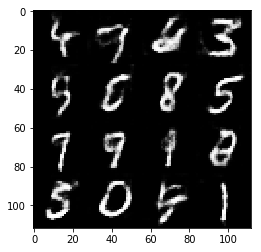

Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.8825
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 0.8569
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.8906
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 1.3701... Generator Loss: 0.9012
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.8174


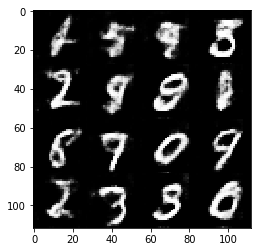

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.8591
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.7699
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.2937... Generator Loss: 0.8733
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.2915... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.8014


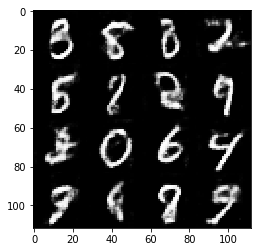

Epoch 2/2... Discriminator Loss: 1.3490... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.8254
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.7967
Epoch 2/2... Discriminator Loss: 1.2742... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.8415


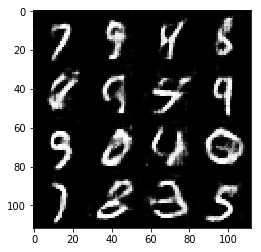

Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.8069
Epoch 2/2... Discriminator Loss: 1.2579... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.8033


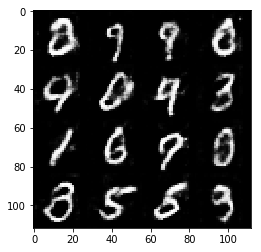

Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.8605


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7466


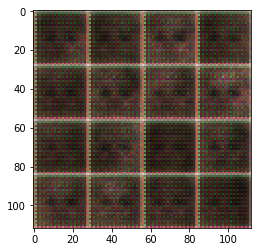

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8007


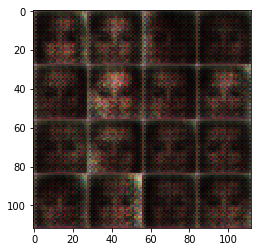

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7884


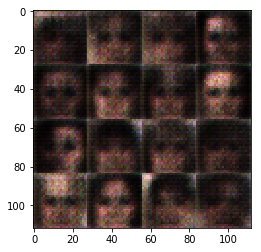

Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7668


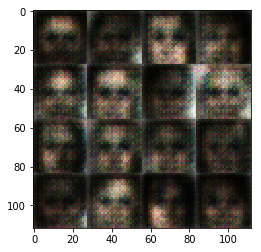

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8449


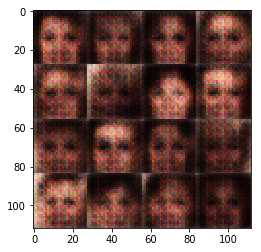

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7889


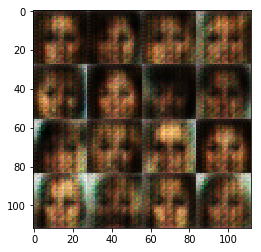

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7855


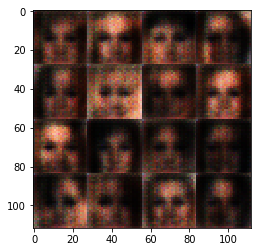

Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8258


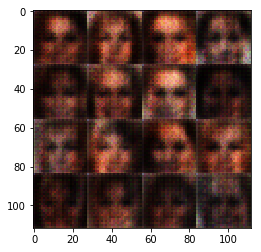

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8154


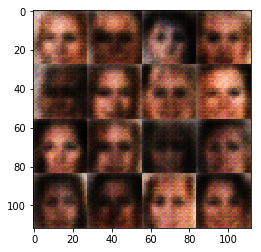

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7745


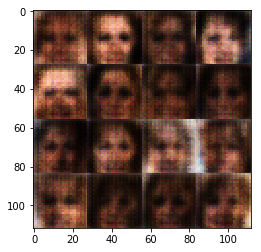

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8065


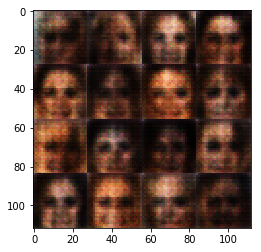

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7911


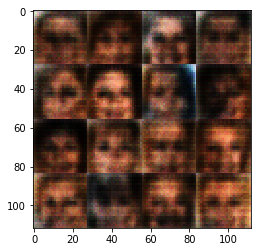

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8129


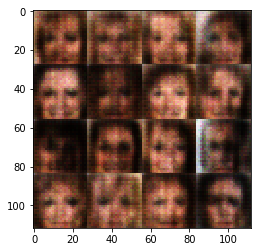

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7942


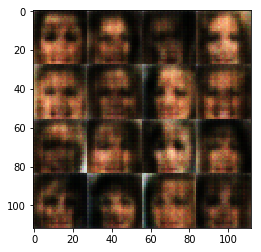

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7453


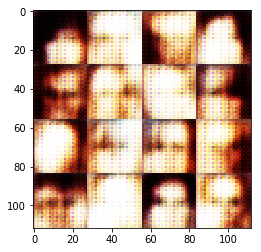

Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 2.0862
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7845


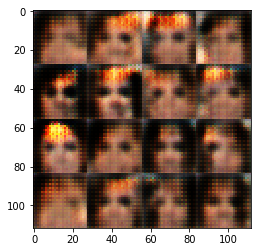

Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.9078
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7730


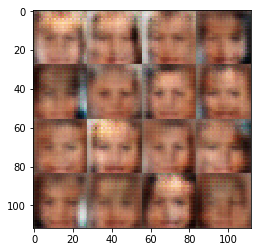

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8348


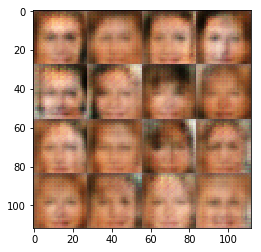

Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8303


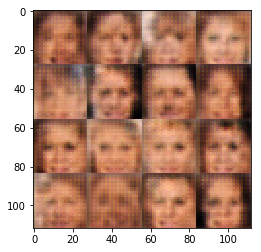

Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.9301


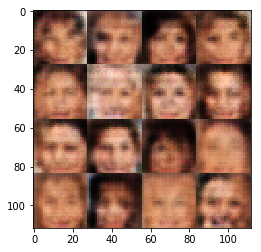

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7960


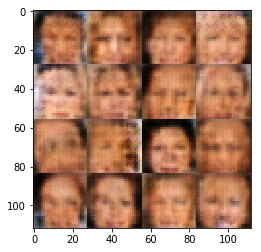

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.0719


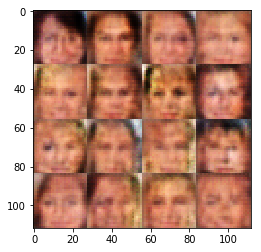

Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.1849


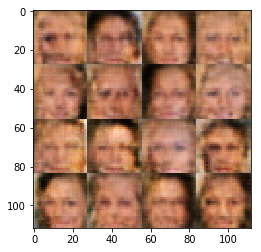

Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7978


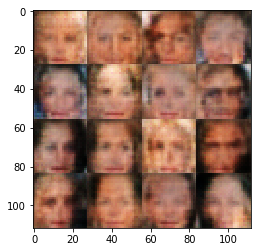

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8557


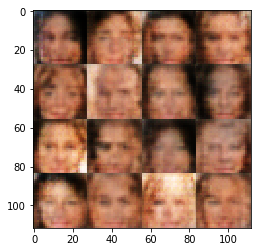

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.0133


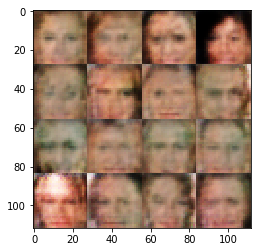

Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.9227


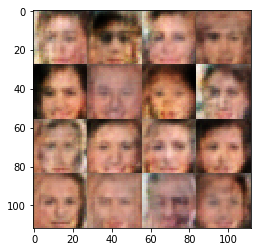

Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.0148


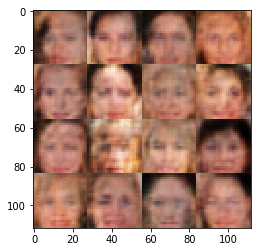

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8906


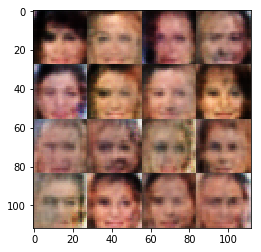

Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.9118


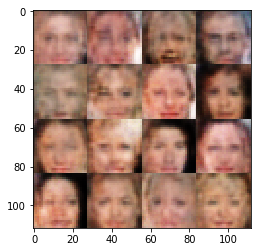

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.9348


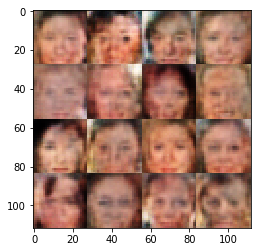

Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 2.4977
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8533


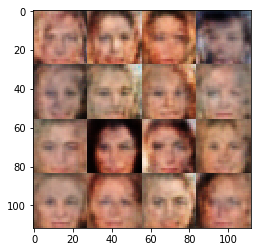

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7873


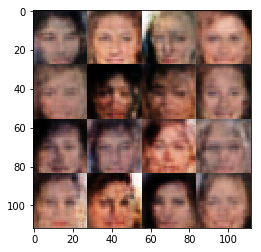

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.2082
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.8160


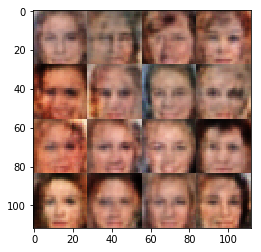

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.5942
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9558


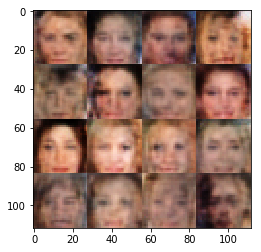

Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7221


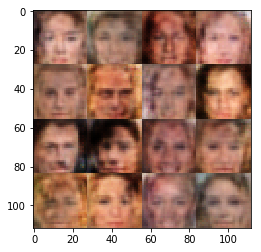

Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.9047


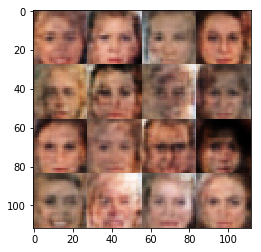

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8962


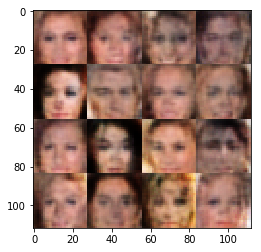

Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8386


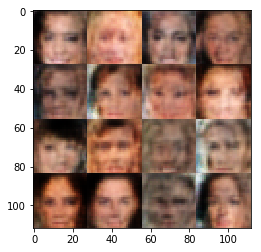

Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8624


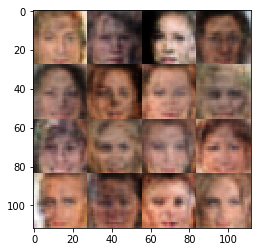

Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.0121
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7785


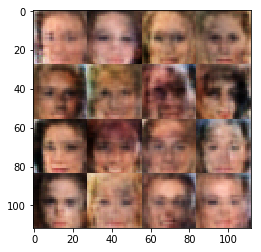

Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7222


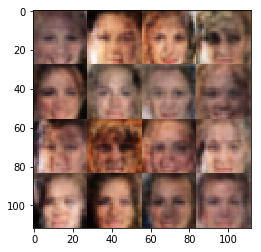

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8225


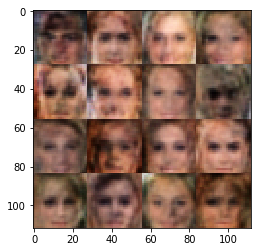

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8628


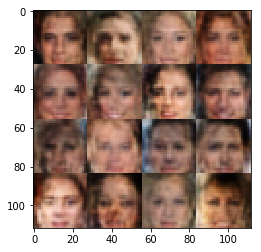

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 1.1929


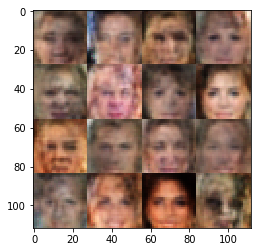

Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8261


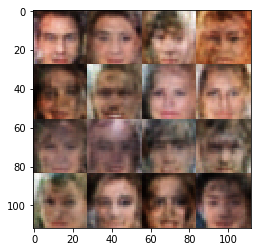

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.0057


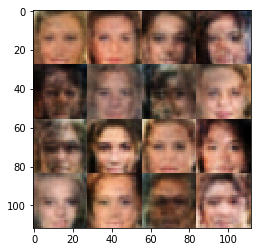

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8376


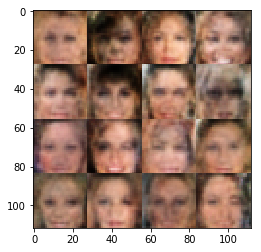

Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.8693


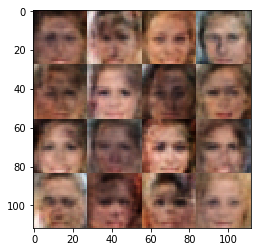

Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8695


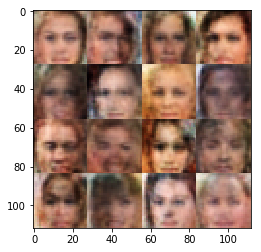

Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.9536


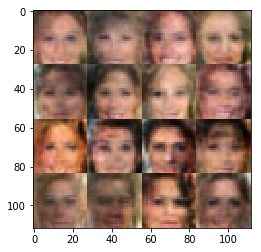

Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8651


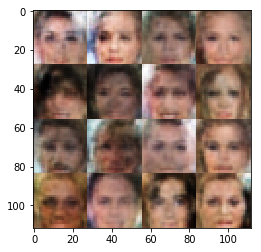

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.9014


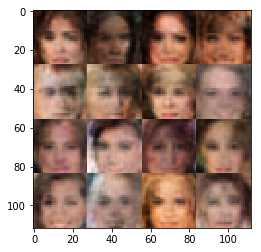

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0728
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8403


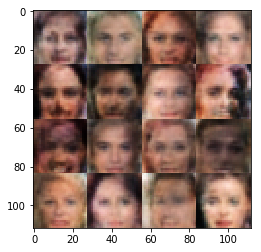

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8734


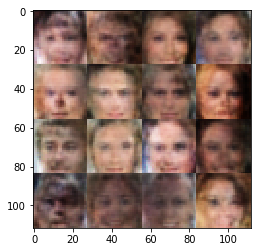

Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.9071


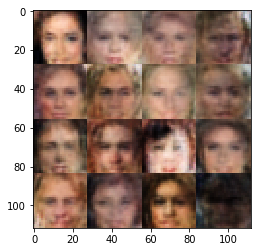

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.7913


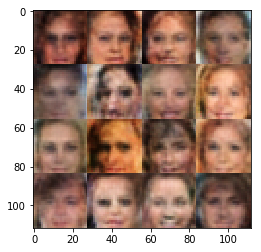

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8164


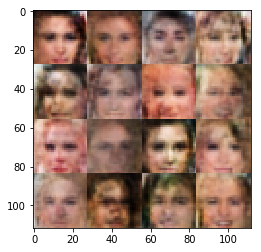

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8561


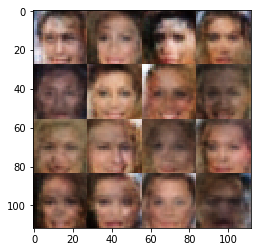

Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.8342


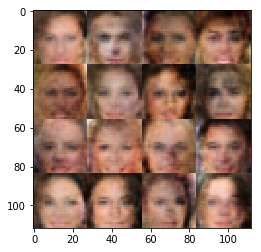

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8177


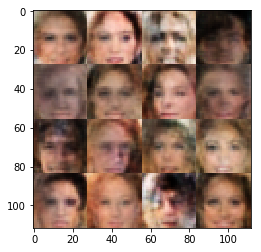

Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8012


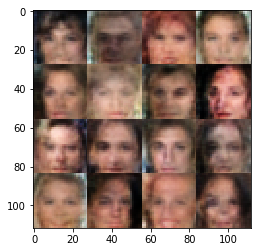

Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8671


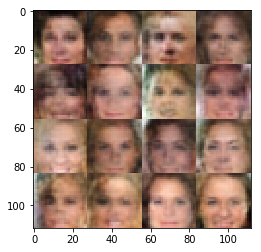

Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8912


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.